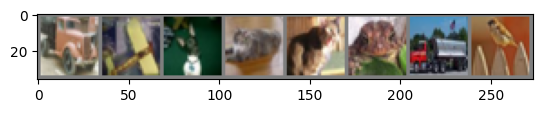

Labels: tensor([9, 0, 5, 3, 3, 6, 9, 2])


In [137]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

def show_images(img):
    img = img / 2 + 0.5  # undo normalization
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(
    root='../data',
    train=True,
    download=True,
    transform=transform
)

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=8,
    shuffle=True
)

imgs, labels = next(iter(trainloader))

show_images(torchvision.utils.make_grid(imgs))
print("Labels:", labels)


In [138]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

class Attention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()

        self.n_heads = n_heads
        self.d_model = d_model

        self.d_k = d_model // n_heads

        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)

        self.out = nn.Linear(d_model, d_model)

    def forward(self, x: torch.tensor):

        query = self.w_q(x) # B, T, C
        key = self.w_k(x)
        value = self.w_v(x)

        query = rearrange(query, "b t (h d) -> b h t d", h=self.n_heads)
        key = rearrange(key, "b t (h d) -> b h t d", h=self.n_heads)
        value = rearrange(value, "b t (h d) -> b h t d", h=self.n_heads)

        attention = torch.einsum("b h i d, b h j d -> b h i j", query, key)
        attention = attention / (self.d_k**0.5)
        attention = F.softmax(attention, dim=-1)

        out = torch.einsum("b h i j, b h j d -> b h i d", attention, value)
        out = rearrange(out, "b h t d -> b t (h d)")
        out = self.out(out)

        return out
        

In [139]:
class FeedForward(nn.Module):
    def __init__(self, d_model, hidden_dim):
        super().__init__()
        self.linear_1 = nn.Linear(d_model, hidden_dim)
        self.GELU = nn.GELU()
        self.linear_2 = nn.Linear(hidden_dim, d_model)

    def forward(self, x):
        x = self.linear_1(x)
        x = self.GELU(x)
        x = self.linear_2(x)
        return x

In [140]:
class PatchEmbedding(nn.Module):
    def __init__(self, patch_size, d_model, in_chanels=3):
        super().__init__()
        self.patch_size = patch_size
        self.in_chanels = in_chanels

        self.projection = nn.Linear(patch_size * patch_size * in_chanels, d_model)

    def forward(self, x: torch.tensor):
        patches = rearrange(
            x, 'b c (h p1) (w p2) -> b (h w) (c p1 p2)',
            p1=self.patch_size, p2=self.patch_size
        )


        out = self.projection(patches)
        return out

In [141]:
class AttentionBlock(nn.Module):
    def __init__(self, d_model, n_heads, hidden_dim):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.attn = Attention(d_model, n_heads)
        self.ln2 = nn.LayerNorm(d_model)
        self.ffn = FeedForward(d_model, hidden_dim)
    
    def forward(self, x: torch.tensor):
        x = x + self.attn(self.ln1(x))
        x = x + self.ffn(self.ln2(x))
        return x

In [142]:
class ViT(nn.Module):
    def __init__(self, d_model, n_heads, hidden_dim, n_layers, patch_size, in_chanels=3):
        super().__init__()

        self.patch_embedding = PatchEmbedding(patch_size, d_model, in_chanels) # B, P, Q

        #pos 
        num_patches = (32 // patch_size) ** 2
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, d_model))
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))

        self.blocks = nn.Sequential(*[AttentionBlock(d_model, n_heads, hidden_dim) for _ in range(n_layers)])

        self.ln = nn.LayerNorm(d_model)
        self.mlp_head = nn.Linear(d_model, 10)

    def forward(self, x: torch.tensor):

        x = self.patch_embedding(x)

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b=x.shape[0])
        x = torch.cat([cls_tokens, x], dim=1)

        x = x + self.pos_embedding

        x = self.blocks(x)

        x = self.ln(x)
        x = x[:, 0]
        x = self.mlp_head(x)
        return x

In [143]:
model = ViT(
    d_model=512,
    n_heads=8,
    hidden_dim=2048,
    n_layers=6,
    patch_size=16
)
print(model)

ViT(
  (patch_embedding): PatchEmbedding(
    (projection): Linear(in_features=768, out_features=512, bias=True)
  )
  (blocks): Sequential(
    (0): AttentionBlock(
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (w_q): Linear(in_features=512, out_features=512, bias=True)
        (w_k): Linear(in_features=512, out_features=512, bias=True)
        (w_v): Linear(in_features=512, out_features=512, bias=True)
        (out): Linear(in_features=512, out_features=512, bias=True)
      )
      (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (ffn): FeedForward(
        (linear_1): Linear(in_features=512, out_features=2048, bias=True)
        (GELU): GELU(approximate='none')
        (linear_2): Linear(in_features=2048, out_features=512, bias=True)
      )
    )
    (1): AttentionBlock(
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (w_q): Linear(in_features=512, out_featur

In [ ]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

device = "cuda" if torch.cuda.is_available() else "cpu"

def train():
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

    model.train()
    for epoch in range(1000):
        # loop = tqdm(trainloader)
        for batch_idx, (data, target) in enumerate(trainloader):

            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            if epoch % 100 == 0:
                print(f"Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item()}")
            break

train()

Epoch: 0, Batch: 0, Loss: 2.340660810470581
Epoch: 100, Batch: 0, Loss: 2.945188283920288
Epoch: 200, Batch: 0, Loss: 2.117142677307129
Epoch: 300, Batch: 0, Loss: 2.593320369720459
Epoch: 400, Batch: 0, Loss: 2.0096347332000732
Epoch: 500, Batch: 0, Loss: 2.1349737644195557
